### Imagenet

Largest image classification dataset at this point of time.

Url: http://image-net.org/

Our setup: classify from a set of 1000 classes.

In [3]:
#classes' names are stored here
import pickle
classes = pickle.load(open('classes.pkl','rb'))
print (classes[::100])

['tench, Tinca tinca', 'black swan, Cygnus atratus', 'Tibetan terrier, chrysanthemum dog', 'tiger beetle', "academic gown, academic robe, judge's robe", 'cliff dwelling', 'hook, claw', 'paper towel', 'slot, one-armed bandit', 'water tower']


### Using pre-trained model: inception
Keras has a number of models for which you can use pre-trained weights. The interface is super-straightforward:

In [4]:
import tensorflow as tf

In [5]:
import keras
import keras.applications as zoo

model = zoo.InceptionV3(include_top=True, weights='imagenet')

In [6]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Predict class probabilities

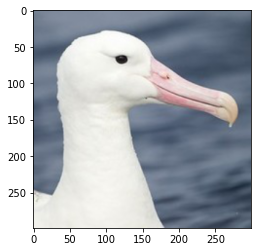

top-10 classes are:
0.9282	albatross
0.0016	turnstile
0.0008	drake
0.0005	collie
0.0004	hammerhead
0.0004	Shetland sheepdog
0.0004	nipple
0.0004	cello
0.0004	goose


In [7]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('albatross.jpg'), (299,  299))
plt.imshow(img)
plt.show()

img_preprocessed = zoo.inception_v3.preprocess_input(img[None].astype('float32') * 255)

probs = model.predict(img_preprocessed)

labels = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are:')
for l in labels:
    print ('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))

### Having fun with pre-trained nets

In [8]:
!wget https://upload.wikimedia.org/wikipedia/en/b/b9/Terminator-2-judgement-day.jpg -O img.jpg

--2021-03-21 19:45:21--  https://upload.wikimedia.org/wikipedia/en/b/b9/Terminator-2-judgement-day.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13726 (13K) [image/jpeg]
Saving to: 'img.jpg'

     0K .......... ...                                        100%  791K=0.02s

2021-03-21 19:45:21 (791 KB/s) - 'img.jpg' saved [13726/13726]



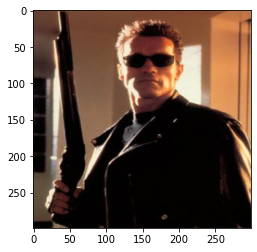

top-10 classes are:
0.4340	sunglass
0.3304	sunglasses
0.0397	rifle
0.0344	trench coat
0.0138	bassoon
0.0096	assault rifle
0.0073	cloak
0.0053	electric guitar
0.0052	suit


In [9]:
img = resize(plt.imread('img.jpg'), (299,299))
plt.imshow(img)
plt.show()

img_preprocessed = zoo.inception_v3.preprocess_input(img[None].astype('float32') * 255.)

probs = model.predict(img_preprocessed)

labels = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are:')
for l in labels:
    print ('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))



### How do you reuse layers

Since model is just a sequence of layers, one can apply it as any other Keras model. Then you can build more layers on top of it, train them and maybe fine-tune "body" weights a bit.

In [10]:
# img = keras.backend.Input('float32',[None,299,299,3])

neck = zoo.InceptionV3(include_top=False, weights='imagenet')(img[None])

hid = keras.layers.GlobalMaxPool2D()(neck)

hid = keras.layers.Dense(512,activation='relu')(hid)

out = keras.layers.Dense(10,activation='softmax')(hid)

#<...> loss, training, etc.

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [31]:
#extract features from images
from tqdm import tqdm
from cv2 import resize
from skimage.io import imread
import os
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = resize(img,(64,64))
    img = zoo.inception_v3.preprocess_input(img[None].astype('float32'))
    
    
    features =img
    Y.append(y)
    X.append(features)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:50<00:00, 226.65it/s]


In [47]:

X=X.reshape(-1,12288)

In [37]:

# X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
# assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [48]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV()

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [55]:
y_train=np.array(y_train)
y_train

array([False, False,  True, ...,  True, False, False])

In [50]:
clf.fit(X_train, y_train)


C:\Users\hovmk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hovmk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\hovmk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hovmk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\hovmk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hovmk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegressionCV()

In [56]:
print("Model accuracy: {:.2f}%".format(clf.score(X_train, y_train)*100))

Model accuracy: 69.17%


__load our dakka__

![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [1]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by setting var_list in the optimizer
      * `opt = tf.train.AdamOptimizer(learning_rate=...)`
      * `opt.minimize(loss,var_list=variables_you_wanna_train)`
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * you can create two update operations
      * `opt1 = tf.train.AdamOptimizer(learning_rate=lr1)`
      * `opt1.minimize(loss,var_list=head_weights)`
      * `opt2 = tf.train.AdamOptimizer(learning_rate=lr2)`
      * `opt2.minimize(loss,var_list=body_weights)`
 
### Grading
* 95% accuracy on test yields 100 points
* -10 points per 5% less accuracy

### Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 96%/97%/98%/99%/99.5% test score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [11]:
#extract features from images
from tqdm import tqdm
from cv2 import resize
from skimage.io import imread
import os
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = resize(img,(64,64))
    img = zoo.inception_v3.preprocess_input(img[None].astype('float32'))
    
    
    features =img
    Y.append(y)
    X.append(features)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [02:18<00:00, 180.94it/s]


In [12]:
import numpy as np
Y=np.array(Y)

In [13]:
X=np.array(X)
X=X.reshape(-1,64,64,3)

In [14]:
Y=1*Y

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)


In [16]:
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42)

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [24]:
model = define_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_194 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

In [26]:
model.fit(
    X_train, y_train,  # prepared data
    batch_size=128,
    epochs=10,
    validation_data=(X_val, y_val),
    shuffle=True,
)

Epoch 1/10
157/157 [==============================] - 111s 686ms/step - loss: 0.6795 - accuracy: 0.5841 - val_loss: 0.6074 - val_accuracy: 0.6684
Epoch 2/10
157/157 [==============================] - 106s 674ms/step - loss: 0.5758 - accuracy: 0.6963 - val_loss: 0.5891 - val_accuracy: 0.6888
Epoch 3/10
157/157 [==============================] - 124s 787ms/step - loss: 0.5454 - accuracy: 0.7252 - val_loss: 0.5564 - val_accuracy: 0.7092
Epoch 4/10
157/157 [==============================] - 110s 698ms/step - loss: 0.5101 - accuracy: 0.7535 - val_loss: 0.6648 - val_accuracy: 0.6580
Epoch 5/10
157/157 [==============================] - 109s 695ms/step - loss: 0.5104 - accuracy: 0.7527 - val_loss: 0.5211 - val_accuracy: 0.7420
Epoch 6/10
157/157 [==============================] - 110s 697ms/step - loss: 0.4704 - accuracy: 0.7784 - val_loss: 0.5496 - val_accuracy: 0.7228
Epoch 7/10
157/157 [==============================] - 122s 777ms/step - loss: 0.4468 - accuracy: 0.7903 - val_loss: 0.5270 -

In [32]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model2():
    # load model
    model = VGG16(include_top=False, input_shape=(64, 64, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [33]:
model = define_model2()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [34]:
model.fit(
    X_train, y_train,  # prepared data
    batch_size=128,
    epochs=10,
    validation_data=(X_val, y_val),
    shuffle=True,
)

Epoch 1/10
157/157 [==============================] - 592s 4s/step - loss: 0.5983 - accuracy: 0.6581 - val_loss: 0.4489 - val_accuracy: 0.7836
Epoch 2/10
157/157 [==============================] - 589s 4s/step - loss: 0.4173 - accuracy: 0.8055 - val_loss: 0.4170 - val_accuracy: 0.8004
Epoch 3/10
157/157 [==============================] - 558s 4s/step - loss: 0.3938 - accuracy: 0.8164 - val_loss: 0.3983 - val_accuracy: 0.8152
Epoch 4/10
157/157 [==============================] - 541s 3s/step - loss: 0.3871 - accuracy: 0.8219 - val_loss: 0.3918 - val_accuracy: 0.8180
Epoch 5/10
157/157 [==============================] - 564s 4s/step - loss: 0.3690 - accuracy: 0.8311 - val_loss: 0.3884 - val_accuracy: 0.8172
Epoch 6/10
157/157 [==============================] - 549s 4s/step - loss: 0.3673 - accuracy: 0.8314 - val_loss: 0.3808 - val_accuracy: 0.8240
Epoch 7/10
157/157 [==============================] - 559s 4s/step - loss: 0.3524 - accuracy: 0.8385 - val_loss: 0.4067 - val_accuracy: 0.8088

# In this example I used Data Augmentation 

In [10]:
import sys
import os
import numpy as np
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import random
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
TRAIN_DIR = 'train/'
TEST_DIR = 'test1/'

ROWS = 150
COLS = 150
CHANNELS = 3
BATCH_SIZE=128

In [11]:
def plot_arr(arr):
    plt.figure()
    plt.imshow(image.array_to_img(arr))
    plt.show()

def plot(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

def prep_data(images):
    count = len(images)
    X = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float32)
    y = np.zeros((count,), dtype=np.float32)
    
    for i, image_file in enumerate(images):
        img = image.load_img(image_file, target_size=(ROWS, COLS))
        X[i] = image.img_to_array(img)
        if 'dog' in image_file:
            y[i] = 1.
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return X, y

original_train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
original_train_images = train_dogs[:12000] + train_cats[:12000]
random.shuffle(original_train_images)
# test_images =  test_images[:100]

# section = int(len(original_train_images) * 0.8)
train_images = original_train_images[:18000]
validation_images = original_train_images[18000:]

X_train, y_train = prep_data(train_images)
X_validation, y_validation = prep_data(validation_images)

train_datagen = image.ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)

validation_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
X_train,
y_train,
batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow(
X_validation,
y_validation,
batch_size=BATCH_SIZE)
# fit model
train_steps = len(train_images)/BATCH_SIZE
validation_steps = len(validation_images)/BATCH_SIZE


Processed 0 of 18000
Processed 1000 of 18000
Processed 2000 of 18000
Processed 3000 of 18000
Processed 4000 of 18000
Processed 5000 of 18000
Processed 6000 of 18000
Processed 7000 of 18000
Processed 8000 of 18000
Processed 9000 of 18000
Processed 10000 of 18000
Processed 11000 of 18000
Processed 12000 of 18000
Processed 13000 of 18000
Processed 14000 of 18000
Processed 15000 of 18000
Processed 16000 of 18000
Processed 17000 of 18000
Processed 0 of 6000
Processed 1000 of 6000
Processed 2000 of 6000
Processed 3000 of 6000
Processed 4000 of 6000
Processed 5000 of 6000


In [15]:

BATCH_SIZE=128
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(150, 150, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model


def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    
  

    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        verbose=2)

# entry point, run the test harness
run_test_harness()

Epoch 1/10


KeyboardInterrupt: 

After executing this cell my computer died, so I was not able to understand how data augmentation can make model better